# EnsembleSwarm calorie burn regression

In [1]:
import pickle
import logging
import shutil
import h5py
import glob
from pathlib import Path
from logging.handlers import RotatingFileHandler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ensembleset.dataset import DataSet
from sklearn.metrics import mean_squared_log_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor

# Import ensembleswarm from source directory rather than installing it from PyPI
%cd ..
import examples.functions.helper_functions as helper_funcs
from ensembleswarm.swarm import Swarm


# Logging configuration
log_name = 'calories'
log_dir = 'examples/logs'

Path(log_dir).mkdir(parents=True, exist_ok=True)
helper_funcs.delete_old_logs(log_dir, log_name)

logging.captureWarnings(True)

logger = logging.getLogger()

logging.basicConfig(
    handlers = [RotatingFileHandler(
        f'{log_dir}/{log_name}.log',
        maxBytes=10 * 1024 * 1024,
        backupCount=10
    )],
    level = logging.INFO,
    format = '%(levelname)s - %(name)s - %(message)s'
)

/mnt/arkk/ensembleswarm


## 1. Load and prepare data

In [2]:
data_df = pd.read_csv('examples/example_data/calories.csv')
data_df.drop('id', axis=1, inplace=True, errors='ignore')
train_df, test_df=train_test_split(data_df, test_size=0.5)
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375000 entries, 0 to 374999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Sex         375000 non-null  object 
 1   Age         375000 non-null  int64  
 2   Height      375000 non-null  float64
 3   Weight      375000 non-null  float64
 4   Duration    375000 non-null  float64
 5   Heart_Rate  375000 non-null  float64
 6   Body_Temp   375000 non-null  float64
 7   Calories    375000 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 22.9+ MB


## 2. EnsembleSwarm model

### 2.1. Optimize model swarm

We will use EnsembleSwarm's built-in hyperparameter tuning function to optimize each model. But first, let's run an experiment with increasing numbers of hyperparameter search iteration to see how runtime and performance improvement scale.

Also, let's set the n_jobs parameter in `RandomizedSearchCV()` intelligently so that regressors which try to use all cores are not forced to thread thrash by SciKit-learn. The following qualitative data was collected by watching htop during a preliminary optimization run with a 3 cross-validation folds per regressor.

- **Linear regression** (has n_jobs): strong all core
- **Quantile regression**: single threaded, strong all core with search jobs = -1
- **KNN**: strong all core
- **Linear SVR**: single threaded, strong all core with search jobs = -1
- **SVR**: single threaded, strong all core with search jobs = -1
- **Gaussian process**: strong all core
- **Decision tree**: single threaded, strong all core with search jobs = -1
- **Random forest** (has n_jobs): single threaded, strong all core with search jobs = -1
- **Gradient boosting**: all core
- **Neural net**: weak all core (sometimes)
- **AdaBoost**: single threaded, strong all core with search jobs = -1
- **SGD**: single threaded, weak all core with search jobs = -1

Set check to run single threaded regressors with `n_jobs = cpu_count() - 2` and all core regressors with `n_jobs = 1` in `RandomizedGridSearchCV()`.

#### 2.1.1. Test grid search iteration number on single ensemble

In [3]:
rerun_iteration_optimization = True
ensembles = 1
frac_features = 0.7
n_steps = 3
cv_folds = 3
sample_size = 1000
random_search_iteration_nums = [4, 8, 16]

ensembleset_file = f'calories_gridsearch_optimization-{ensembles}-{frac_features}-{n_steps}.h5'
swarm_directory = 'examples/swarms/calories_gridsearch_optimization'
results_file = 'examples/results/calorie_gridsearch_optimization.csv'

In [4]:
if Path(f'examples/ensemblesets/{ensembleset_file}').is_file() is False:

    data_ensemble = DataSet(
        label='Calories',
        train_data=train_df,
        test_data=test_df,
        string_features=['Sex'],
        data_directory='examples/ensemblesets',
        ensembleset_base_name='calories_gridsearch_optimization'
    )

    _ = data_ensemble.make_datasets(
        n_datasets=ensembles,
        frac_features=frac_features,
        n_steps=n_steps
    )

In [5]:
if Path(results_file).is_file() is False and rerun_iteration_optimization is True:
    results = []

    swarm = Swarm(
        ensembleset=f'examples/ensemblesets/{ensembleset_file}',
        swarm_directory=swarm_directory
    )

    for n in random_search_iteration_nums:
        print(f'\nRunning {n} random search iterations.')

        try:
            shutil.rmtree(swarm_directory)

        except OSError as e:
            pass

        result = swarm.optimize_swarm(
            sample=sample_size,
            cv=cv_folds,
            default_n_iter=n
        )
        
        result['iterations'] = [n]*len(result['model'])

        results.append(pd.DataFrame(result))

In [6]:
if Path(results_file).is_file() is False and rerun_iteration_optimization is True:
    results_df = pd.concat(results, axis=0)
    results_df['efficiency_mean'] = results_df['score_mean'] / results_df['time']
    results_df['efficiency_std'] = results_df['score_std'] / results_df['time']
    results_df.to_csv(results_file, index=False)

else:
    results_df = pd.read_csv(results_file)

In [7]:
results_df.head()

,ensemble,model,time,score_mean,score_std,iterations,efficiency_mean,efficiency_std
0,0,Linear regression,1.387103,71.946852,85.867957,4,51.868425,61.904525
1,0,Quantile regression,0.870377,9.183004,1.012878,4,10.550602,1.163723
2,0,Nearest Neighbors,0.281612,6.003762,0.204375,4,21.319295,0.725734
3,0,Linear SVM,0.373719,7.664246,0.465504,4,20.508059,1.245600
4,0,RBF SVM,0.496129,24.420234,3.102951,4,49.221537,6.254323


#### 2.1.2. Optimization runtime and score vs iteration number

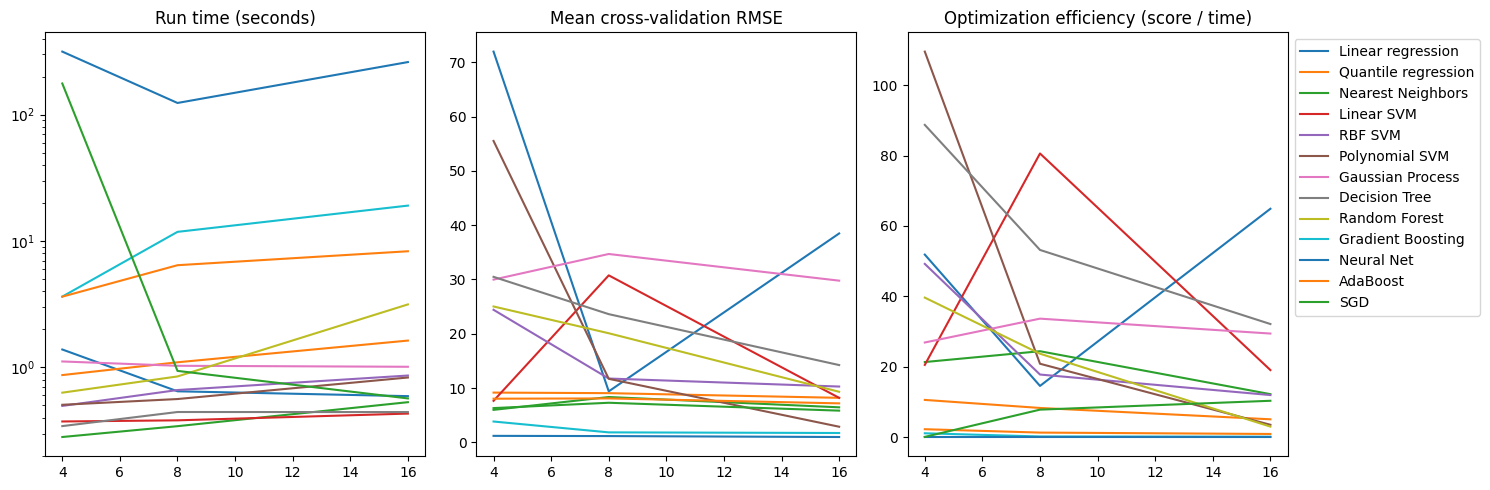

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs.flatten()
axs[0].set_title('Run time (seconds)')
axs[1].set_title('Mean cross-validation RMSE')
axs[2].set_title('Optimization efficiency (score / time)')
axs[0].set_yscale('log')

color = plt.cm.viridis(np.linspace(0, 1, len(results_df['model'].unique())))

for ax, y_var in zip(axs, ['time', 'score_mean', 'efficiency_mean']):
    for model in results_df['model'].unique():
        plot_df=results_df[results_df['model'] == model]
        ax.plot(plot_df['iterations'], plot_df[y_var], label=model)

axs[2].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.5)
fig.tight_layout()

### 2.2. Multi-ensemble swarm training run

Based on the above results, let's select our models and gridsearch iterations, then optimize over a multi-ensemble swarm using a small sample of the data.

In [9]:
reoptimize_swarm = False
retrain_swarm = True
generate_swarm_output = True

ensembles = 3
frac_features = 0.7
n_steps = 3
optimization_sample_size = 100
training_sample_size = 500
default_n_iter = 16

model_n_iter = {
    'Neural Net': 8,
    'RBF SVM': 8,
    'Random Forest': 16,
    'Decision Tree': 16,
    'Nearest Neighbors': 4,
}

models = [
    'Nearest Neighbors',
    'RBF SVM',
    'Polynomial SVM',
    'Decision Tree',
    'Random Forest',
    'Gradient Boosting',
    'Neural Net'
]

ensembleset_file = f'calories-{ensembles}-{frac_features}-{n_steps}.h5'
swarm_directory = 'examples/swarms/calories'
swarm_optimization_results_file = 'examples/results/calorie_swarm_optimization.csv'
swarm_output_file = 'examples/results/calorie_swarm_output.csv'
swarm_rmse_file = 'examples/results/calorie_swarm_rmse.csv'

#### 2.2.1. Create the ensembleset

In [10]:
if Path(f'examples/ensemblesets/{ensembleset_file}').is_file() is False:

    data_ensemble = DataSet(
        label='Calories',
        train_data=train_df,
        test_data=test_df,
        string_features=['Sex'],
        data_directory='examples/ensemblesets',
        ensembleset_base_name='calories'
    )

    _ = data_ensemble.make_datasets(
        n_datasets=ensembles,
        frac_features=frac_features,
        n_steps=n_steps
    )

#### 2.2.2. Create and optimize the model swarm

In [11]:
swarm = Swarm(
    ensembleset=f'examples/ensemblesets/{ensembleset_file}',
    swarm_directory=swarm_directory,
    model_types=models
)

In [12]:
%%time

if reoptimize_swarm is True:

    result_df = swarm.optimize_swarm(
        sample=optimization_sample_size,
        default_n_iter=default_n_iter,
        model_n_iter=model_n_iter,
    )

    results_df.to_csv(swarm_optimization_results_file, index=False)

    print('\n')

CPU times: user 9 μs, sys: 1 μs, total: 10 μs
Wall time: 16.9 μs


**Note**: takes about 2 hours, 15 minutes to run on a 5k sample with three ensembles.

#### 2.2.4. Train the model swarm

Now we use the per-model and per-ensemble hyperparameters optimized on a small sample of the data to train the swarm on the full dataset.

In [13]:
%%time

if retrain_swarm is True:
    
    swarm.train_swarm(
        sample=training_sample_size
    )

CPU times: user 307 ms, sys: 444 ms, total: 751 ms
Wall time: 35 s


**Note**: takes about 9 hours to run on the complete dataset with three ensembles.

### 2.3. Swarm test set predictions

In [ ]:
%%time

if generate_swarm_output is True:

    level_two_df, swarm_rmse_df = swarm.swarm_predict()
    level_two_df.to_csv(swarm_output_file, index=False)
    swarm_rmse_df.to_csv(swarm_rmse_file, index=False)

else:
    level_two_df = pd.read_csv(swarm_output_file)
    swarm_rmse_df = pd.read_csv(swarm_rmse_file)

print('\n')

Running Neural Net, ensemble 3 of 3, elapsed time: 0 sec.                                 
CPU times: user 3min 24s, sys: 6.26 s, total: 3min 30s
Wall time: 2min 26s


#### 2.3.1. Swarm RMSE distribution

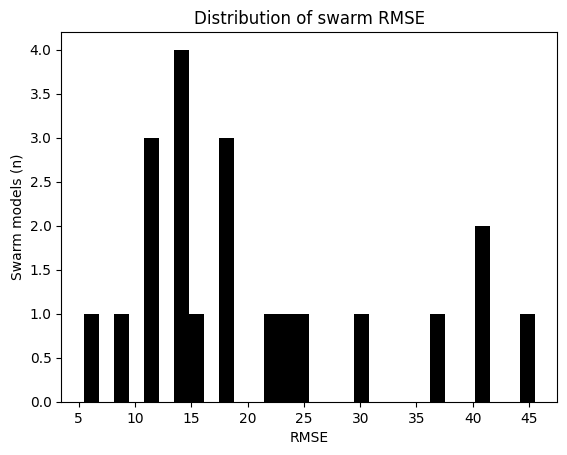

In [15]:
plt.title('Distribution of swarm RMSE')
plt.hist(swarm_rmse_df['RMSE'], color='black', bins=30)
plt.xlabel('RMSE')
plt.ylabel('Swarm models (n)')
plt.show()

#### 2.3.2. Individual model scores

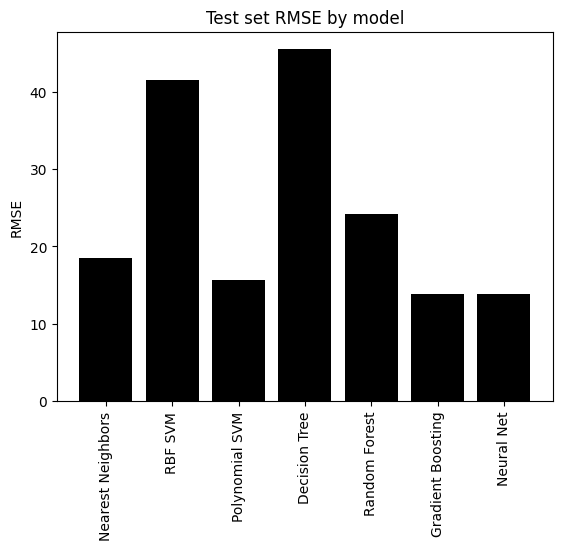

In [16]:
plt.title('Test set RMSE by model')
plt.bar(swarm_rmse_df['model'], height=swarm_rmse_df['RMSE'], color = 'black')
plt.ylabel('RMSE')
plt.xticks(rotation=90)
plt.show()

### 2.4. Swarm level II model cross-validation

In [17]:
scores = cross_val_score(
    HistGradientBoostingRegressor(loss='gamma'),
    level_two_df.drop('label', axis=1),
    level_two_df['label'],
    scoring='neg_mean_squared_log_error',
    n_jobs=-1,
    cv=7
)

print(f'Cross-validation RMSLE: {np.mean(np.sqrt(-scores)):.4f} +/- {np.std(np.sqrt(-scores)):.4f}')

Cross-validation RMSLE: 0.0715 +/- 0.0009
